Sentimental Analysis using Bert

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import nltk
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [ ]:
datasets = pd.read_json("/content/drive/MyDrive/Colab_Notebooks/Amazon_Instant_Video_5.json", lines=True, orient='records')
datasets.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,"02 11, 2009"


In [ ]:
print(len(datasets))
datasets.drop_duplicates(subset=['reviewText'], inplace = True)
print(len(datasets))

37126
37117


In [ ]:
datasets = datasets.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime'], axis=1)
datasets.head()

,reviewText,overall
0,I had big expectations because I love English ...,2
1,I highly recommend this series. It is a must f...,5
2,This one is a real snoozer. Don't believe anyt...,1
3,Mysteries are interesting. The tension betwee...,4
4,"This show always is excellent, as far as briti...",5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


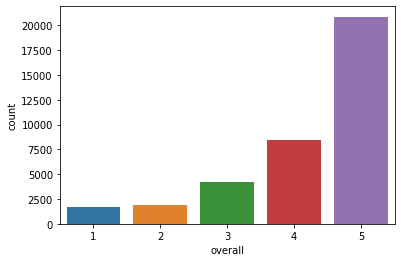

In [ ]:
sns.countplot(datasets['overall'])

In [ ]:
def labelling(x): # negative = 0, positive = 1
  if x<4:
    return 0
  elif x>4:
    return 2
  else:
    return 1

In [ ]:
datasets['overall'] = pd.to_numeric(datasets['overall'])
datasets['overall'] = datasets['overall'].apply(labelling)
datasets

,reviewText,overall
0,I had big expectations because I love English ...,0
1,I highly recommend this series. It is a must f...,2
2,This one is a real snoozer. Don't believe anyt...,0
3,Mysteries are interesting. The tension betwee...,1
4,"This show always is excellent, as far as briti...",2
...,...,...
37121,I love the books! The show is amazing so far. ...,2
37122,"""The Strain"" has potential to be an excellent ...",2
37123,"I'm not real sure on how, I should rate this s...",0
37124,episode one so far makes me want to watch more...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


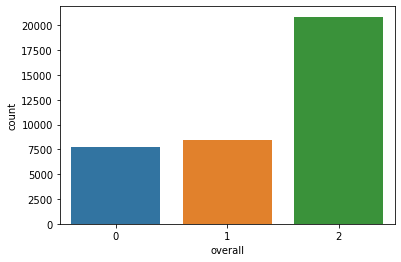

In [ ]:
sns.countplot(datasets['overall'])

In [ ]:
def decontractions(phrase):
    '''Performs decontractions in the doc'''

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"shouldn\'t", "should not", phrase)
    phrase = re.sub(r"wouldn\'t", "would not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
        
    return phrase

In [ ]:
def preprocess(text):
    
    punctuations = set(string.punctuation)
    stop_words = stopwords.words('english')
    new_text = []
    new_score = []
    for line, score in text.values:
        if len(line.split()) == 1 and line in stop_words:
            continue
        else:
            # lowercase
            line = line.lower()
            # removes punctuations
            temp = []
            for i in line:
                if i in punctuations or i.isdigit():
                    continue
                else:
                    temp.append(i)
                line = ''.join(e for e in temp)
            line = re.sub('<.*?>', ' ', line)
            # performs decontractions
            line = decontractions(line)
            # removes multiple spaces
            line = re.sub(' +', ' ', line)
            
            temp = []
            for word in line.split():
                if len(word) < 2:
                    continue
                else:
                    temp.append(word)
            line = ' '.join(e for e in temp)
            
            new_text.append(line)
            new_score.append(score)
            
    
    datasets = pd.DataFrame()
    datasets['reviewText'] = new_text
    datasets['overall'] = new_score
    
    datasets.to_json('Amazon_Instant_Video_preprocessed.json')
    return datasets

In [ ]:
nltk.download('stopwords')
datasets = preprocess(datasets)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
datasets.shape

(37117, 2)

In [ ]:
datasets.head()

,reviewText,overall
0,had big expectations because love english tv i...,0
1,highly recommend this series it is must for an...,2
2,this one is real snoozer dont believe anything...,0
3,mysteries are interesting the tension between ...,1
4,this show always is excellent as far as britis...,2


In [ ]:
pip install transformers

     |████████████████████████████████| 3.5 MB 17.5 MB/s 
     |████████████████████████████████| 6.8 MB 48.1 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 61.8 MB/s 
     |████████████████████████████████| 895 kB 69.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datasets['reviewText'], datasets['overall'], test_size = 0.2, random_state=101, 
                                                    stratify = datasets['overall'])

In [ ]:
y_train.value_counts(), y_test.value_counts()

(2    16706
 1     6756
 0     6231
 Name: overall, dtype: int64, 2    4177
 1    1689
 0    1558
 Name: overall, dtype: int64)

In [ ]:
# length_train = []
# for i in X_train:
#     length_train.append(len(i.split()))
length_train = []

for i in X_train:
  tokens = bert_tokenizer.encode(i, max_length=510, truncation=True)
  length_train.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


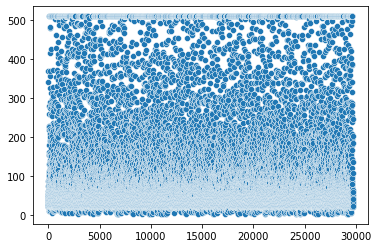

In [ ]:
sns.scatterplot(range(X_train.shape[0]), length_train)

In [ ]:
max_length = max(length_train) + 2 # for cls and sep tokens
max_length

512

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


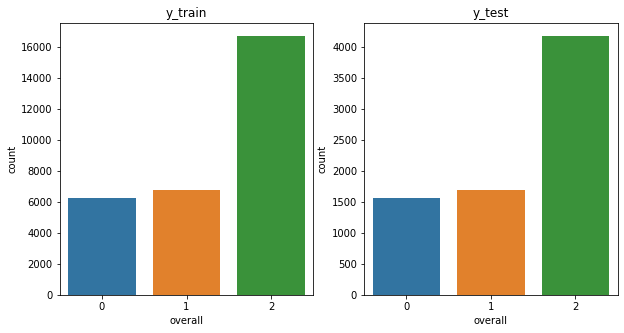

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('y_train')
sns.countplot(y_train)
plt.subplot(122)
plt.title('y_test')
sns.countplot(y_test)

In [ ]:
def tokenization(X, max_length):
    X_mask = np.zeros((X.shape[0], max_length))
    X_segment = np.zeros((X.shape[0], max_length))
    X_new = []
    for i in range(len(X.values)):
        temp = bert_tokenizer.encode(X.values[i], pad_to_max_length = True, max_length = max_length, truncation=True)
        X_new.append(temp)
        for j in range(max_length):
            if temp[j] != 0:
                X_mask[i][j] = 1
            else:
                continue
        
    return np.array(X_new), X_mask, X_segment

In [ ]:
X_train_tok, X_train_mask, X_train_segment = tokenization(X_train, max_length)
X_test_tok, X_test_mask, X_test_segment = tokenization(X_test, max_length)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
import pickle

In [ ]:
pickle.dump((X_train, X_train_tok, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tok, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")

input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")

segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")
 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [ ]:
X_train_output = bert_model.predict([X_train_tok, X_train_mask, X_train_segment])
X_test_output = bert_model.predict([X_test_tok, X_test_mask, X_test_segment])

In [ ]:
for i in tqdm(range(1, 100)):  
  X_train_output = bert_model.predict([X_train_tok, X_train_mask, X_train_segment])
  X_test_output = bert_model.predict([X_test_tok, X_test_mask, X_test_segment])

In [ ]:
pickle.dump((X_train_output, X_test_output), open('Text_Features_from_BERT.pkl','wb'))
y_train_OHE = tf.keras.utils.to_categorical(y_train, 3)
y_test_OHE = tf.keras.utils.to_categorical(y_test, 3)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(n_jobs=-1)
model_lr = lr.fit(X_train_output, y_train)

In [ ]:
lr.predict(X_test_output[9].reshape(1,-1))

In [ ]:
lr_predictions = lr.predict(X_test_output)

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test.values, lr_predictions), cmap='Reds', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
class scoring(tf.keras.callbacks.Callback):
    
    def __init__(self, validation_data):
        self.validation_data = validation_data
    def on_train_begin(self, logs={}):
        self.auc=0
    def on_epoch_end(self, epoch, logs={}):
        
        predictions = self.model.predict(self.validation_data[0])
        y_val = self.validation_data[1]
     #   pred = []
        print(predictions.shape)
    #    for i in range(predictions.shape[0]):
    #       pred.append(np.argmax(predictions[i]))
        
        self.auc = roc_auc_score(y_val, predictions, multi_class='ovr')
        
        print("AUC: {}".format(self.auc))

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout
input_layer = Input(shape=(768,), name='Input_layer')
dense1 = Dense(256, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(), name='Dense1')(input_layer)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(256, activation = 'relu', kernel_initializer=tf.keras.initializers.he_normal(), name='Dense2')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

In [ ]:
import datetime

optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy'])
log_dir="Tensorboard\logs_m2\\fit4\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint('Weights/Model_logsm2_fit4_best.h5', verbose=1, save_best_only=True)
auc = scoring((X_test_output, y_test))


In [ ]:
model.fit(X_train_output, y_train_OHE, epochs = 10, validation_data=(X_test_output, y_test_OHE), batch_size = 32,
          callbacks=[tensorboard_callback, checkpoint, auc], verbose = 1)